In [96]:
import sklearn
import keras
import nltk
import pandas as pd
import numpy as np
import re
import codecs
import seaborn as sns
import matplotlib.pyplot as plt

import numpy as np
import itertools
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, r2_score, classification_report

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Шаги для анализа тональности с использованием датасета

## Загрузка и исследование данных.
  Подготовьте ваш датасет. Датасет должен содержать тексты и их метки тональности (например, позитивный, негативный, нейтральный).

In [39]:
url = '/content/drive/My Drive/Colab Notebooks/Tweets.csv'
data = pd.read_csv(url,encoding='utf-8')

In [32]:
questions.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


В датасете есть цензура, скрывающая ругательства. На модели это не сильно должно повлиять, так как они смотрят больше на контекст.

In [33]:
data.describe(include='O')

,textID,text,selected_text,sentiment
count,27481,27480,27480,27481
unique,27481,27480,22463,3
top,cb774db0d1,"I`d have responded, if I were going",good,neutral
freq,1,1,199,11118


In [56]:
data['sentiment'].unique()

array(['neutral', 'negative', 'positive'], dtype=object)

<Axes: xlabel='sentiment', ylabel='Count'>

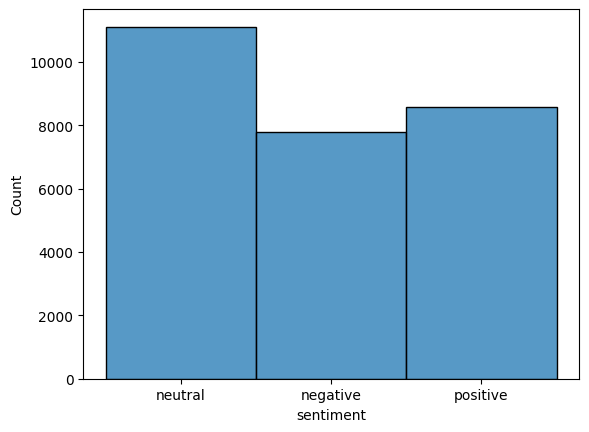

In [58]:
sns.histplot(data['sentiment'])

In [34]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27481 entries, 0 to 27480
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   textID         27481 non-null  object
 1   text           27480 non-null  object
 2   selected_text  27480 non-null  object
 3   sentiment      27481 non-null  object
dtypes: object(4)
memory usage: 858.9+ KB


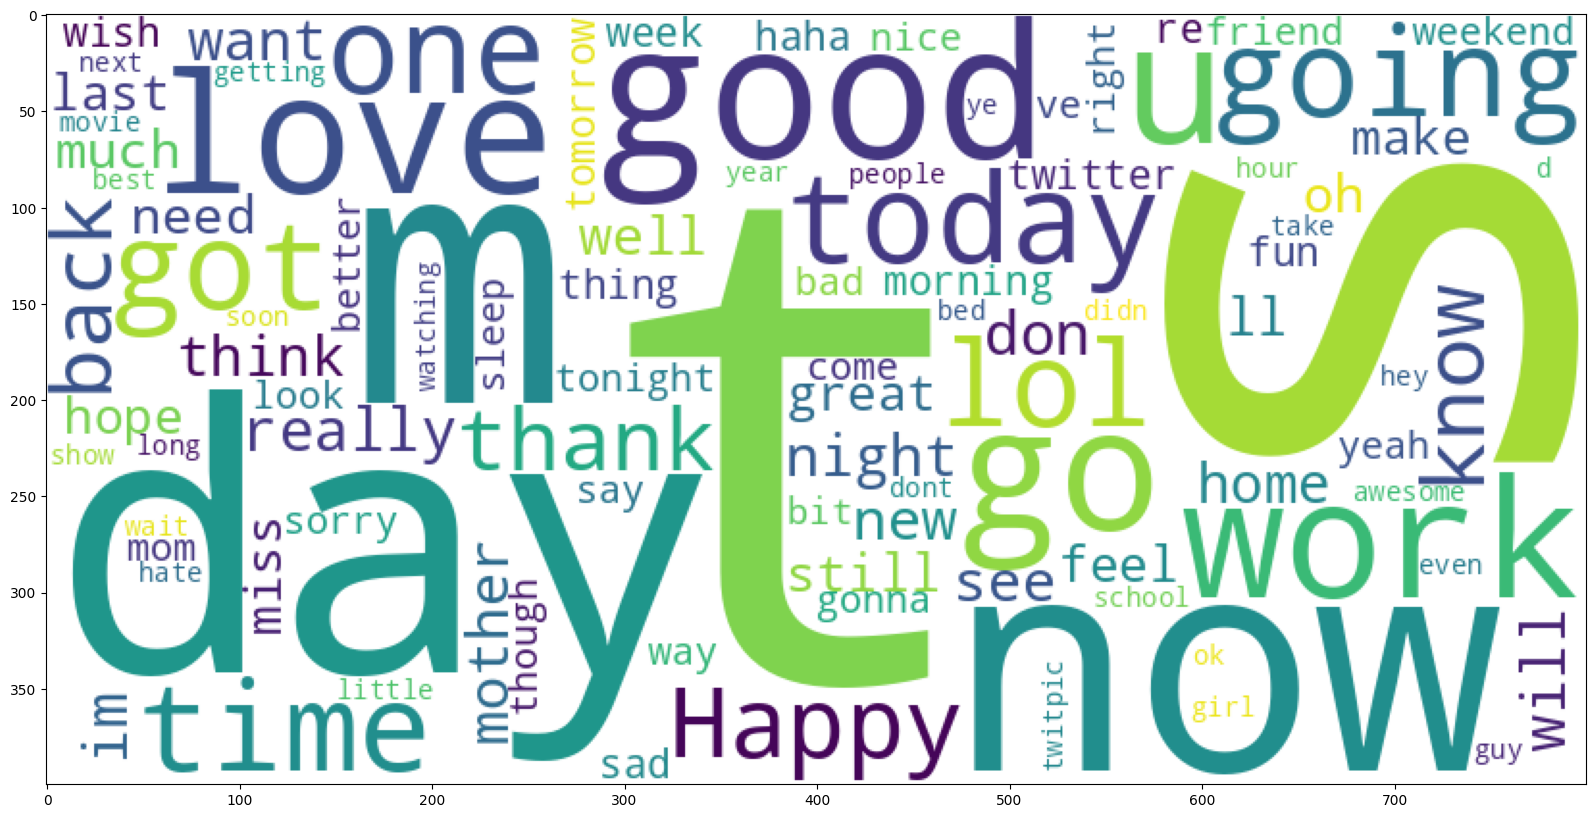

In [98]:
from wordcloud import WordCloud

a = " ".join(data["text"])
en_cloud = WordCloud(max_words=100, background_color='white',
                     width=800, height=400,
                     collocations=False).generate(a)
fig = plt.figure(figsize=(20, 10))
plt.imshow(en_cloud)

## Предобработка текста
Тексты в реальном мире часто содержат шум. Очистите их, удалив лишние символы, приведение слов к нормальной форме (лемматизация), преобразование в нижний регистр и удаление стоп-слов.

In [35]:
data[data.isna().any(axis=1)]

,textID,text,selected_text,sentiment
314,fdb77c3752,NaN,NaN,neutral


Удалим запись с пропусками

In [79]:
data = data.dropna()
data[data.isna().any(axis=1)]

,textID,text,selected_text,sentiment,Processed_text,Processed_selected_text


In [41]:
# Загрузка необходимых ресурсов NLTK
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')

import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

def preprocess_text(text):
    # Приведение к нижнему регистру
    text = text.lower()
    # Удаление специальных символов и чисел
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Токенизация
    tokens = word_tokenize(text)
    # Удаление стоп-слов
    tokens = [word for word in tokens if word not in stopwords.words('english')]
    # Лемматизация
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return ' '.join(tokens)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [42]:
# Применение предобработки к датасету
data['Processed_text'] = data['text'].apply(preprocess_text)
data['Processed_selected_text'] = data['selected_text'].apply(preprocess_text)

## Разделение на обучающую и тестовую выборки
Разделите данные на обучающую и тестовую выборки.

In [53]:
from sklearn.model_selection import train_test_split

X = data['Processed_selected_text']
y = data['sentiment']

# Разделение на обучающие и тестовые данные
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Создание модели
Будем использовать классические алгоритмы, такие как Naive Bayes, или глубокие модели, такие как transformers.

### Пример с использованием Naive Bayes:

In [84]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline

# Создаём конвейер: векторизация текста + классификатор
model_naive_bayes = make_pipeline(CountVectorizer(), MultinomialNB())

# Обучение модели
model_naive_bayes.fit(X_train, y_train)

# Оценка модели
accuracy = model_naive_bayes.score(X_test, y_test)
print(f"Model Accuracy: {accuracy:.2f}")

Model Accuracy: 0.77


#### Посмотрим результаты прогнозирования

In [81]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.winter):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=20)
    plt.yticks(tick_marks, classes, fontsize=20)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center",
                 color="white" if cm[i, j] < thresh else "black", fontsize=40)

    plt.tight_layout()
    plt.ylabel('True label', fontsize=30)
    plt.xlabel('Predicted label', fontsize=30)

    return plt

In [83]:
def get_metrics(y_test, y_predicted):
    # true positives / (true positives+false positives)
    precision = precision_score(y_test, y_predicted, pos_label=None,
                                    average='weighted')
    # true positives / (true positives + false negatives)
    recall = recall_score(y_test, y_predicted, pos_label=None,
                              average='weighted')

    # harmonic mean of precision and recall
    f1 = f1_score(y_test, y_predicted, pos_label=None, average='weighted')

    r2 = r2_score(y_test, y_predicted)
    # true positives + true negatives/ total
    accuracy = accuracy_score(y_test, y_predicted)
    return accuracy, precision, recall, f1, r2

In [86]:
predictions = model_naive_bayes.predict(X_test)
accuracy, precision, recall, f1, r2 = get_metrics(y_test, predictions)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f, r2 = %.3f" % (accuracy, precision, recall, f1,r2))

accuracy = 0.773, precision = 0.795, recall = 0.773, f1 = 0.771, r2 = 0.506


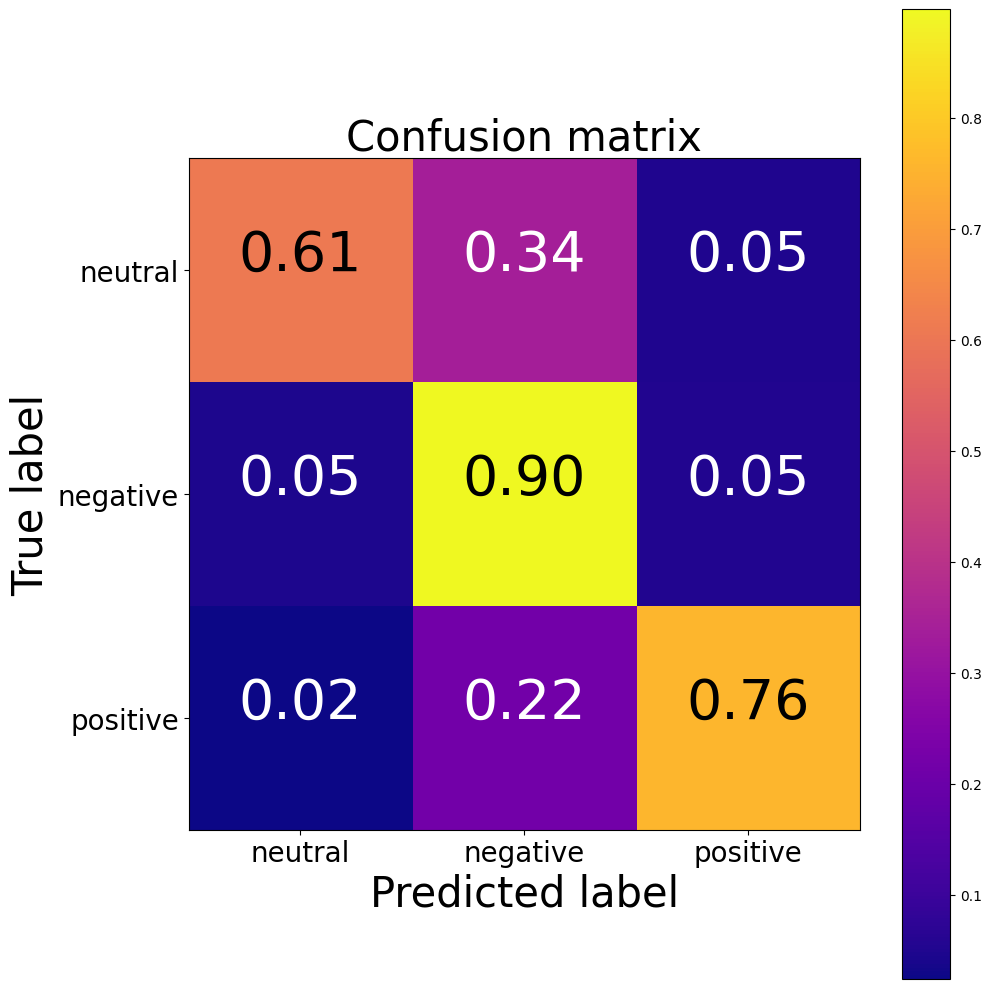

In [88]:
cm = confusion_matrix(y_test, predictions)
fig = plt.figure(figsize=(10, 10))
plot = plot_confusion_matrix(cm, classes=sentiment, normalize=True, title='Confusion matrix', cmap="plasma")
plt.show()

### Пример с использованием SVM:

In [91]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC

# Векторизация текста
vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Обучение SVM модели
svm_model = SVC(kernel='linear')
svm_model.fit(X_train_tfidf, y_train)

# Оценка модели
accuracy = svm_model.score(X_test_tfidf, y_test)
print(f"SVM Model Accuracy: {accuracy:.2f}")

SVM Model Accuracy: 0.79


#### Посмотрим результаты прогнозирования

In [92]:
predictions = svm_model.predict(X_test_tfidf)
accuracy, precision, recall, f1, r2 = get_metrics(y_test, predictions)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f, r2 = %.3f" % (accuracy, precision, recall, f1,r2))

accuracy = 0.794, precision = 0.803, recall = 0.794, f1 = 0.794, r2 = 0.535


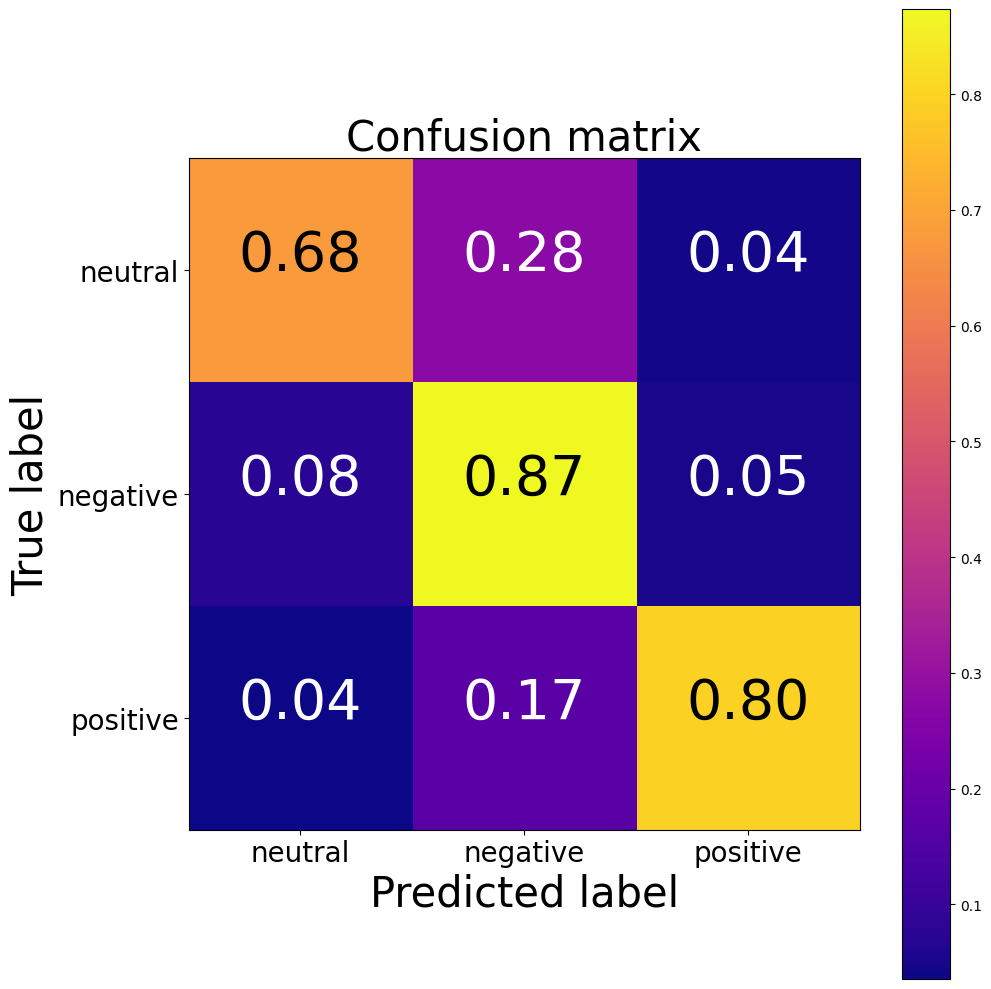

In [93]:
cm = confusion_matrix(y_test, predictions)
fig = plt.figure(figsize=(10, 10))
plot = plot_confusion_matrix(cm, classes=sentiment, normalize=True, title='Confusion matrix', cmap="plasma")
plt.show()

### Пример с глубоким обучением (используя TensorFlow)
Если датасет большой, можно обучить нейронную сеть.

In [62]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)

# Токенизация текста
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Паддинг последовательностей
X_train_pad = pad_sequences(X_train_seq, maxlen=100)
X_test_pad = pad_sequences(X_test_seq, maxlen=100)

# Создание модели
model = Sequential([
    Embedding(input_dim=5000, output_dim=64, input_length=100),
    LSTM(64),
    Dense(64, activation='relu'),
    Dense(3, activation='softmax')  # Для трех классов (Positive, Negative, Neutral)
])

# Компиляция модели
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Обучение модели
model.fit(X_train_pad, y_train, epochs=5, validation_data=(X_test_pad, y_test))

Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


687/687 ━━━━━━━━━━━━━━━━━━━━ 39s 54ms/step - accuracy: 0.6497 - loss: 0.7854 - val_accuracy: 0.7902 - val_loss: 0.5214
Epoch 2/5
687/687 ━━━━━━━━━━━━━━━━━━━━ 38s 56ms/step - accuracy: 0.8466 - loss: 0.4178 - val_accuracy: 0.8055 - val_loss: 0.5084
Epoch 3/5
687/687 ━━━━━━━━━━━━━━━━━━━━ 39s 52ms/step - accuracy: 0.8748 - loss: 0.3434 - val_accuracy: 0.8080 - val_loss: 0.5383
Epoch 4/5
687/687 ━━━━━━━━━━━━━━━━━━━━ 41s 53ms/step - accuracy: 0.8846 - loss: 0.3172 - val_accuracy: 0.7980 - val_loss: 0.5628
Epoch 5/5
687/687 ━━━━━━━━━━━━━━━━━━━━ 41s 53ms/step - accuracy: 0.8980 - loss: 0.2821 - val_accuracy: 0.7989 - val_loss: 0.5913


#### Посмотрим результаты прогнозирования

In [69]:
sentiment = data['sentiment'].unique()

In [70]:
# Прогнозирование
new_text = "Sooo SAD I will miss you here in San Diego!!!"

new_text_seq = tokenizer.texts_to_sequences([preprocess_text(new_text)])
new_text_pad = pad_sequences(new_text_seq, maxlen=100)
prediction = model.predict(new_text_pad)
predicted_class = prediction.argmax(axis=1)
print(f"Predicted Sentiment Class: {sentiment[predicted_class[0]]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Predicted Sentiment Class: negative


In [65]:
predictions = model.predict(X_test_pad)
predicted_classes = predictions.argmax(axis=1)
accuracy = accuracy_score(y_test, predicted_classes)
print(f"Model Accuracy on Test Data: {accuracy:.2f}")

172/172 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step
Model Accuracy on Test Data: 0.80


Использование текстов из колонки 'text'

In [72]:
X1 = data['Processed_text']
y1 = label_encoder.fit_transform(data['sentiment'])

X1_seq = tokenizer.texts_to_sequences(X1)

# Паддинг последовательностей
X1_pad = pad_sequences(X1_seq, maxlen=100)
predictions = model.predict(X1_pad)
predicted_classes = predictions.argmax(axis=1)
accuracy = accuracy_score(y1, predicted_classes)
print(f"Model Accuracy on Test Data: {accuracy:.2f}")

859/859 ━━━━━━━━━━━━━━━━━━━━ 13s 15ms/step
Model Accuracy on Test Data: 0.64


In [82]:
predictions = model.predict(X_test_pad)
predicted_classes = predictions.argmax(axis=1)
accuracy, precision, recall, f1, r2 = get_metrics(y_test, predicted_classes)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f, r2 = %.3f" % (accuracy, precision, recall, f1,r2))

172/172 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step
accuracy = 0.799, precision = 0.802, recall = 0.799, f1 = 0.799, r2 = 0.450


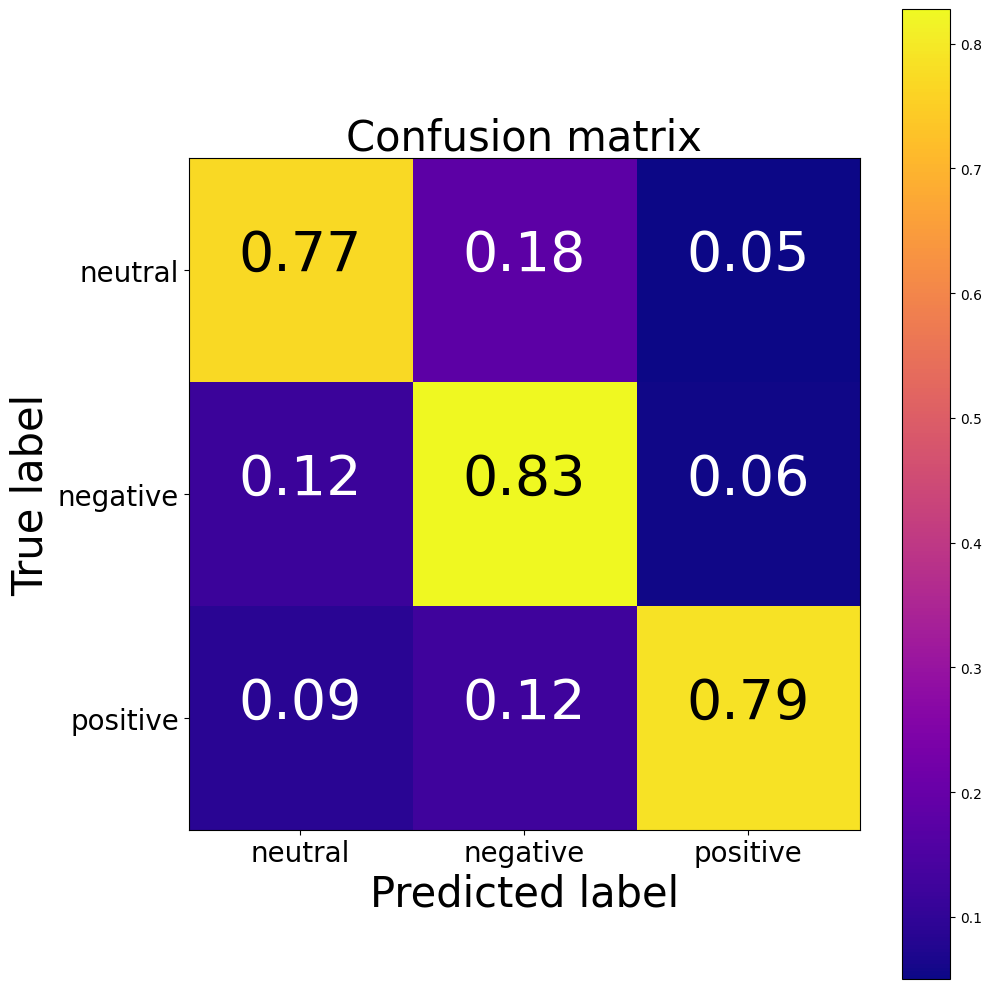

In [76]:
cm = confusion_matrix(y_test, predicted_classes)
fig = plt.figure(figsize=(10, 10))
plot = plot_confusion_matrix(cm, classes=sentiment, normalize=True, title='Confusion matrix', cmap="plasma")
plt.show()

## Выводы

Использование TensorFlow оказалось хорошим вариантом.  
Хоть и есть некоторые сложности.  
Остальные модели приведенные в работе, тоже показали не плохой результат.

Определение тональности текста не сложная задача.  
В работе попытался продемонстрировать несколько из вариантов реализации, сильно не углубляясь в тему.